# Pits, SMP, and SSA Oh My 

The notebook attempts to use the database to find all the SMP profiles associated with Pits where SSA was also measured 

We have micro-ct data from the pits:

* 1S17  
* 2N13
* 2S16 
* 2S7 
* 9C16

We can use these to determine which of the SMP profile file names should be downloaded. We are currently only focused on the smp profiles nearest the pit

In [4]:
# Import the function to get connect to the db
from snowexsql.db import get_db

# Our Integrating Sphere SSA and SMP data in the DB are under layers
from snowexsql.data import LayerData

# Grab our handy functions to convert records to dataframes
from snowexsql.conversions import query_to_geopandas

# Use pandas for concatting dataframes 
import geopandas as gpd 

import os 
import matplotlib.pyplot as plt 


# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@52.32.183.144/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name, credentials=None)

# Sites where Micro-ct was collected
sites = ['1S17', '2N13', '2S16', '2S7','9C16']

# Change this to overwrite the files we stored in git, this will create git tracked changes in data
write_ssa_to_file = True


## Find our SMP profiles

We are interested in the SMP profiles taken at the pit, indicated in the pandas dataframe as p


In [ ]:
def get_filename_from_meta(meta_row):
    """
    Reproduce the filename from the smp metadata xls/csv sheet.
    """    
    f_str = 'SNEX20_SMP_S{}M{}_{}_{}.PNT'
    
    # instrument IDs were used to indicate. In the meta 19 sometimes has a b but not in the file names
    serial_num  = meta_row['SMP instrument # '].replace('b','')
    f_suffix =  meta_row['Fname sufix']
    site_id = meta_row['Pit ID']
    dt_str = meta_row['Date'].replace('-','').split(' ')[0]
    return f_str.format(serial_num, f_suffix, site_id, dt_str)
 
    
# Import the SMP meta file as a dataframe 
smp_meta = pd.read_csv('../data/SNEX20_SMP_FieldNotes.csv', header=9)    
    
for sid in sites:
    print(f'\nProfiles next to the pit at site = {sid}:')
    # filter the meta on pit id
    ind1 = smp_meta['Pit ID'] == sid
    
    # Grab by orientation only at the pit 
    ind2 = smp_meta['Orientation'] == 'P'
    
    # Apply our filters
    df = smp_meta.loc[ind1 & ind2]
    
    df['filename'] = df.apply(lambda row: get_filename_from_meta(row), axis=1)
    print(df['filename'].values)
                                                        

# Grab our SSA profiles

Grab our SSA by site id and write the profile to data. 

[datetime.date(2020, 2, 8)]
Writing data out to ../data/SSA/DB_SSA_1S17.csv...


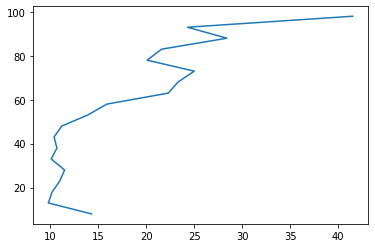

[datetime.date(2020, 2, 6)]
Writing data out to ../data/SSA/DB_SSA_2N13.csv...


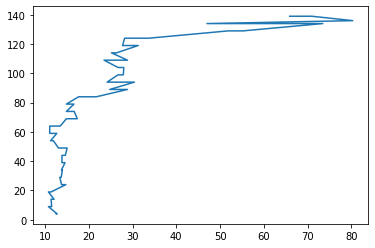

[datetime.date(2020, 2, 8)]
Writing data out to ../data/SSA/DB_SSA_2S16.csv...


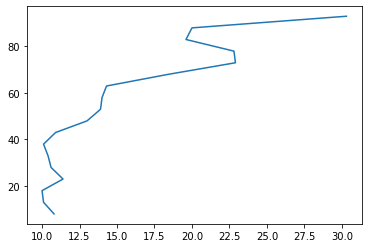

[datetime.date(2020, 2, 8)]
Writing data out to ../data/SSA/DB_SSA_2S7.csv...


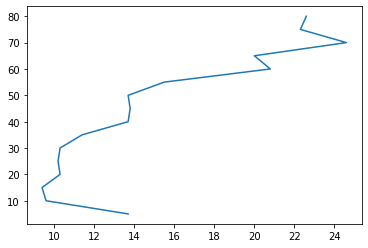

[datetime.date(2020, 2, 5)]
Writing data out to ../data/SSA/DB_SSA_9C16.csv...


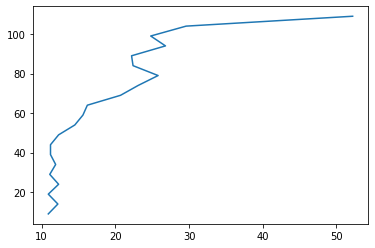

In [5]:
output = '../data/SSA/'

if not os.path.isdir(output):
    os.mkdir(output)

for sid in sites:
    # Grab all the columns in layer data
    qry = session.query(LayerData)
    # Only grab ssa
    qry = qry.filter(LayerData.type == 'specific_surface_area')
    
    # Filter by this pit
    qry = qry.filter(LayerData.site_id == sid)

    # Order the values by depth 
    qry = qry.order_by('depth')
    
    # Cast it to geopandas 
    df = query_to_geopandas(qry, engine)
    
    # Values in layers are always strings so cast this as a float
    df['value'] = df['value'].astype(float)
    
    # Prove to ourselves there only one day this was done at these pits.
    date = df['date'].unique()
    print(date)
    
    # Save the data 
    if write_ssa_to_file:
        out_f = os.path.join(output, f'DB_SSA_{sid}.csv')
        print(f'Writing data out to {out_f}...')
        df.to_csv(out_f, index=False)
        
    plt.plot(df['value'], df['depth'])
    plt.show()

In [ ]:
session.close()